In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data

Basic data cleaning includes deleting the puctuation marks in the titles, and convert text into lower case.

In [2]:
import string

titles = pd.read_csv("./data/medium_post_titles.csv")
titles.drop(columns=["subtitle", "subtitle_truncated_flag"], inplace=True)

titles.title = titles.title.str.replace('[{}]'.format(string.punctuation), '').str.lower()
titles.title = titles.title.str.replace('‘', '')
titles.title = titles.title.str.replace('’', '')
titles.title = titles.title.str.replace('“', '')
titles.title = titles.title.str.replace('”', '')
titles.title = titles.title.str.replace('—', '')

titles.head()

,category,title
0,work,21 conversations a fun and easy game for team...
1,spirituality,biblical porn at mars hill
2,lgbtqia,cisgender is that a disease
3,equality,call me nat love black cowboys and the frontie...
4,artificial-intelligence,can i train my model on your computer


Hold out 20% of data as the test set.

In [3]:
from sklearn.model_selection import train_test_split

titles_train, titles_test = train_test_split(titles, train_size=0.8, stratify=titles.category.values)

X_train = titles_train.title.values
X_test = titles_test.title.values

y_train = titles_train.category.values
y_test = titles_test.category.values

# Naive Bayess

Use TF-IDF to perform bag-of-words vectorization.

We adopted the Penn Treebank Tokenizer. We want to include n-grams up to 2 words. Terms that appear less than twice or occur in more than half of the docuemnts are rejected. Typically, with TF-IDF vectorization, we can still use a multinominal naive Bayess classifier. Let's take a look at a naive Bayess classifer with no hyper-parameter tuning (minimum Lapalace smoohing). 

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

tokenizer = TreebankWordTokenizer()
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, ngram_range=(1, 2), stop_words='english', min_df=2, max_df=0.5)

NBclassifier = MultinomialNB(alpha=0)

classifier = Pipeline([("TfIdf", vectorizer), ("NaiveBayess", NBclassifier)])

accuracy = cross_val_score(classifier, X_train,y=y_train, cv=5, n_jobs=-2).mean()
print("accuracy = {}".format(accuracy))

accuracy = 0.29724937785375716


## Parameter tuning

With our choice of parameters, the accuracy is just shy of 30% (5-fold cross validation with the training set) which is not ideal. Thus, tuning of the hyper-parameters by cross-validation is necessary. We focused on the pseudo-count for the naive Bayess classifier, the length of ngrams and the prevalence criterion for words to be included in the vocabulary.

In [6]:
from sklearn.model_selection import GridSearchCV

vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, stop_words='english')
NBclassifier = MultinomialNB()
classifier = Pipeline([("TfIdf", vectorizer), ("NaiveBayess", NBclassifier)])

parameter_space = {"TfIdf__ngram_range": [(1, 1), (1, 2), (1, 3)],\
                   "TfIdf__min_df": [1, 2, 10, 100],\
                   "TfIdf__max_df": [0.1, 0.25, 0.5],\
                   "NaiveBayess__alpha": [0, 0.01, 0.1, 1, 10],}
searcher = GridSearchCV(classifier, parameter_space, cv=5, n_jobs=-2)
searcher.fit(X_train, y_train)

best_parameter = searcher.best_params_
print("hyper-parameter of choice: " + str(best_parameter))

hyper-parameter of choice: {'NaiveBayess__alpha': 0.1, 'TfIdf__max_df': 0.1, 'TfIdf__min_df': 2, 'TfIdf__ngram_range': (1, 1)}


In [7]:
from sklearn.metrics import accuracy_score

y_pred = searcher.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("accuracy = {}".format(accuracy))

accuracy = 0.3529109318145863


The "best" hyperparameters generate a accuracy of about 35% on the hold-out test set.

In [8]:
def plotConfusionMatrix(confusionMatrix, classes):
    
    confusionMatrix = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
    
    heatmap_df = pd.DataFrame(confusionMatrix, index=classes, columns=classes)
    
    fig, ax = plt.subplots(figsize=(16,13))
    sns.heatmap(heatmap_df, xticklabels=True,yticklabels=True, ax=ax, vmin=0,vmax=1)
    ax.set_aspect("equal")
    plt.title("Confusion Matrix", fontsize=20)
    plt.ylabel("true category", fontsize=15)
    plt.xlabel("predicted category", fontsize=15)

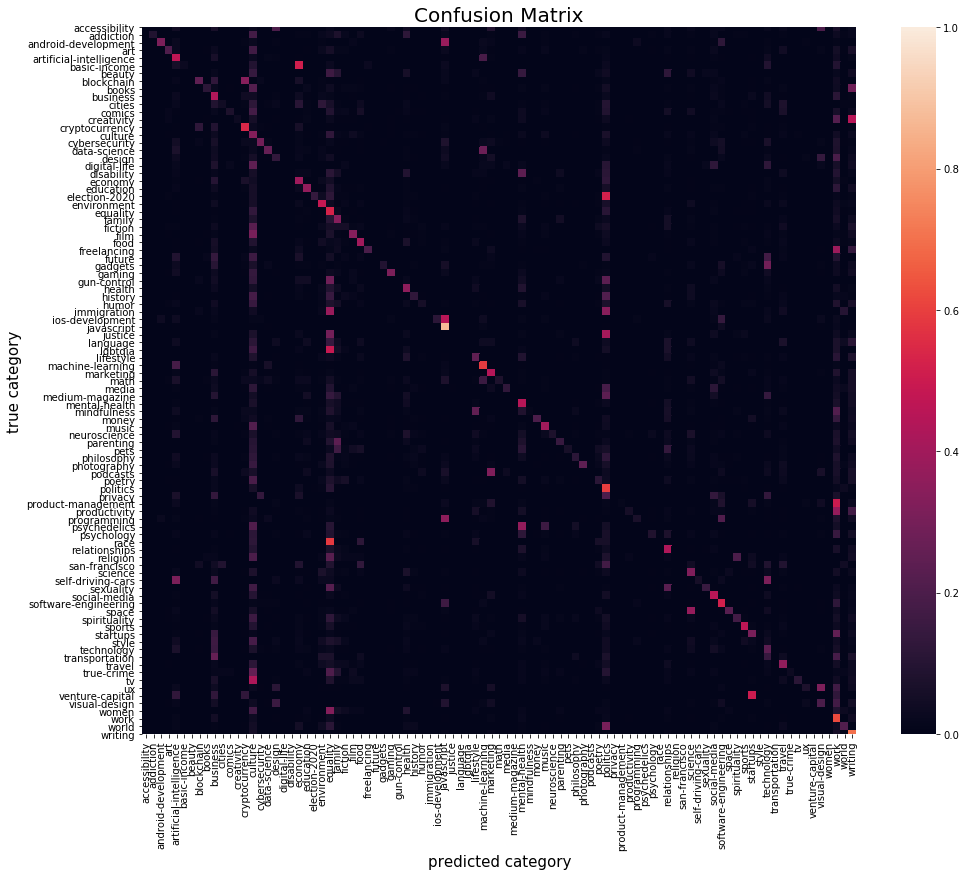

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

category_list = unique_labels(y_test, y_pred)

cMatrix = confusion_matrix(y_test, y_pred, labels=category_list)

plotConfusionMatrix(cMatrix, category_list)

There are some major pairs of misclassification, partly due to those involved category are tightly related -- _venture-capital_ misclassified as *business*; _basic-income_ misclassified as *economy*; _election-2020_ misclassified as *politics*; *lgbtqia*, _race_ and _women_ misclassified as _equality_...

In [10]:
from tqdm import tqdm

def generateMeanRepresentation(X,y, categoryList, vectorizer):
    
    X = vectorizer.transform(X)
    vocabulary = np.array(vectorizer.get_feature_names())
    
    most_significant_by_category = {}
    average_significance_by_category_matrix = np.matrix([])
    for c in tqdm(categoryList, ):
    
        row_index = np.where(c == y)
        X_c = X[row_index]
        if X_c.size == 0:
            continue

        average_significance = X_c.mean(axis=0)
        if average_significance_by_category_matrix.size == 0:
            average_significance_by_category_matrix = average_significance
        else:
            average_significance_by_category_matrix = np.concatenate([average_significance_by_category_matrix, average_significance])
        average_significance = average_significance.getA()[0]

        bag_of_words = vocabulary[average_significance > 0]
        average_significance = average_significance[average_significance > 0]
        sort_index = average_significance.argsort()[::-1]
        bag_of_words = bag_of_words[sort_index]
        average_significance = average_significance[sort_index]

        most_significant_by_category[c] = (bag_of_words, average_significance)
        
    return most_significant_by_category, average_significance_by_category_matrix

In [11]:
vectorizer = searcher.best_estimator_.steps[0][1]
mostSignificant_true, _ = generateMeanRepresentation(X_test,y_test, category_list, vectorizer)
mostSignificant_pred, _ = generateMeanRepresentation(X_test,y_pred, category_list, vectorizer)

100%|██████████| 93/93 [00:00<00:00, 223.44it/s]


In [12]:
from wordcloud import WordCloud

def drawWordCloud(category, words,freq):
    
    word_freq = dict(zip(words, freq))
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_freq)

    fig, ax = plt.subplots(figsize=(16,9))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    plt.title(category, fontsize=20)

Entries in many categories were misclassified into _culture_. Among them, _tv_ and _film_ caused major confusions.

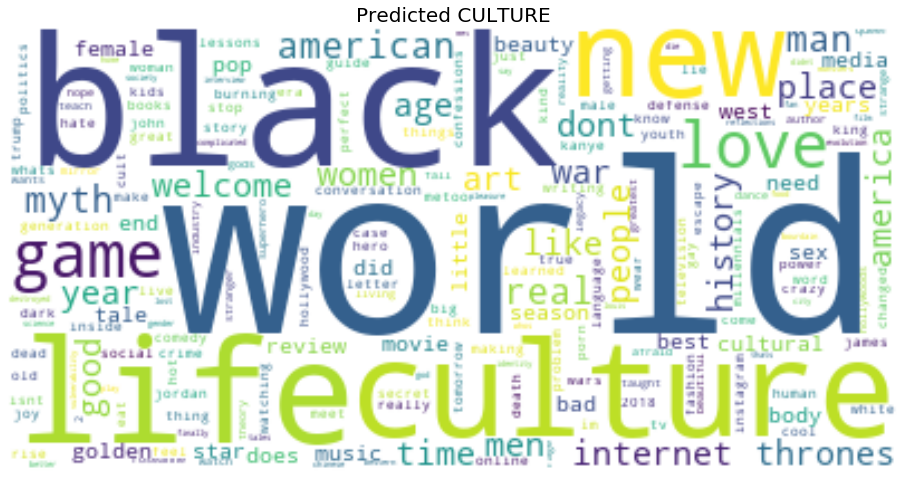

In [13]:
drawWordCloud("Predicted CULTURE", mostSignificant_pred["culture"][0], mostSignificant_pred["culture"][1])

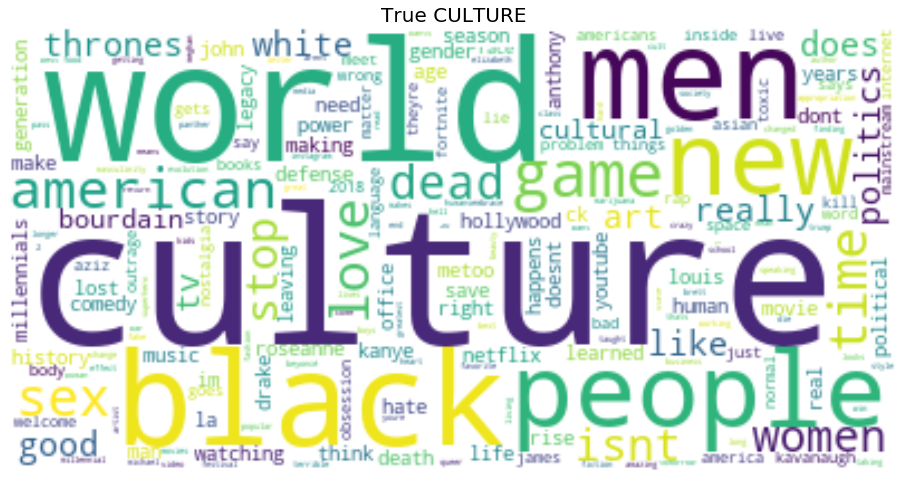

In [14]:
drawWordCloud("True CULTURE", mostSignificant_true["culture"][0], mostSignificant_true["culture"][1])

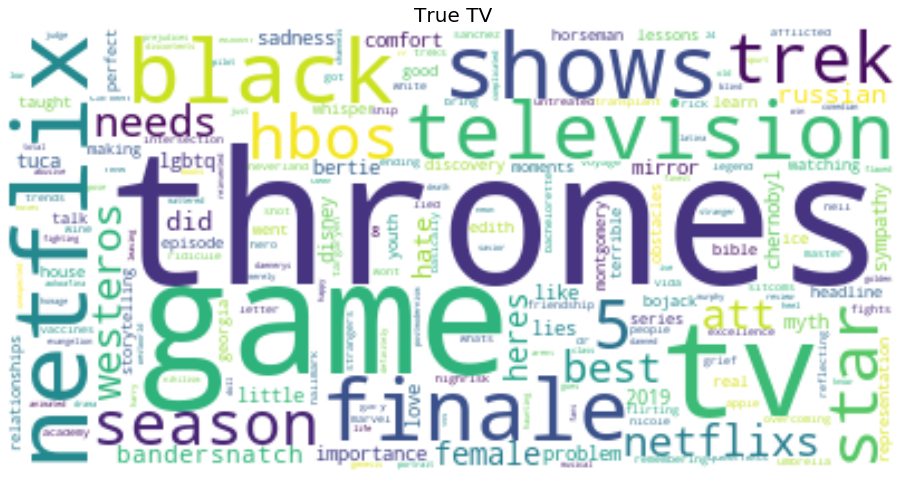

In [15]:
drawWordCloud("True TV", mostSignificant_true["tv"][0], mostSignificant_true["tv"][1])

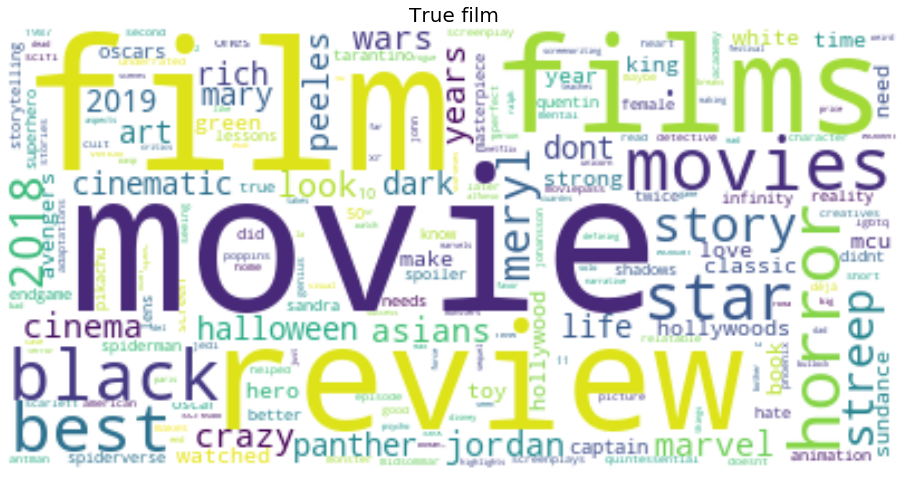

In [16]:
drawWordCloud("True film", mostSignificant_true["film"][0], mostSignificant_true["film"][1])

If we take a look of words with high TF-IDF scores, we'll see that both 'movie' and 'tv' are icluded in words assotiaced with the true _culture_ class. A lot of other major features are also shared by either _film_ or _tv_ with *culture*, and made major contribution in the misclassified _culture_ class, for instance, 'hollywood', 'game', 'thrones', 'black', 'netflix' and so on.

In [27]:
def precisionFromConfusionMatrix(confusionMatrix):
    
    truePos = np.diagonal(confusionMatrix)
    falsePos = np.asarray(confusionMatrix.sum(axis=0)) - truePos
    
    precision = truePos / (truePos + falsePos)
    precision = precision[~np.isnan(precision)]
    
    return precision.mean()

precision = precisionFromConfusionMatrix(cMatrix)
print("Average multiclass precision: {}".format(precision))

Average multiclass precision: 0.46143906929422135


On average, the precesion for a theme reached about 46%

## Dimension reduction

hyper-parameter of choice: {'TfIdf__max_df': 0.5, 'TfIdf__min_df': 1, 'TfIdf__ngram_range': (1, 3)}
accuracy = 0.1011311501344724
Average multiclass precision: 0.1455671968491009


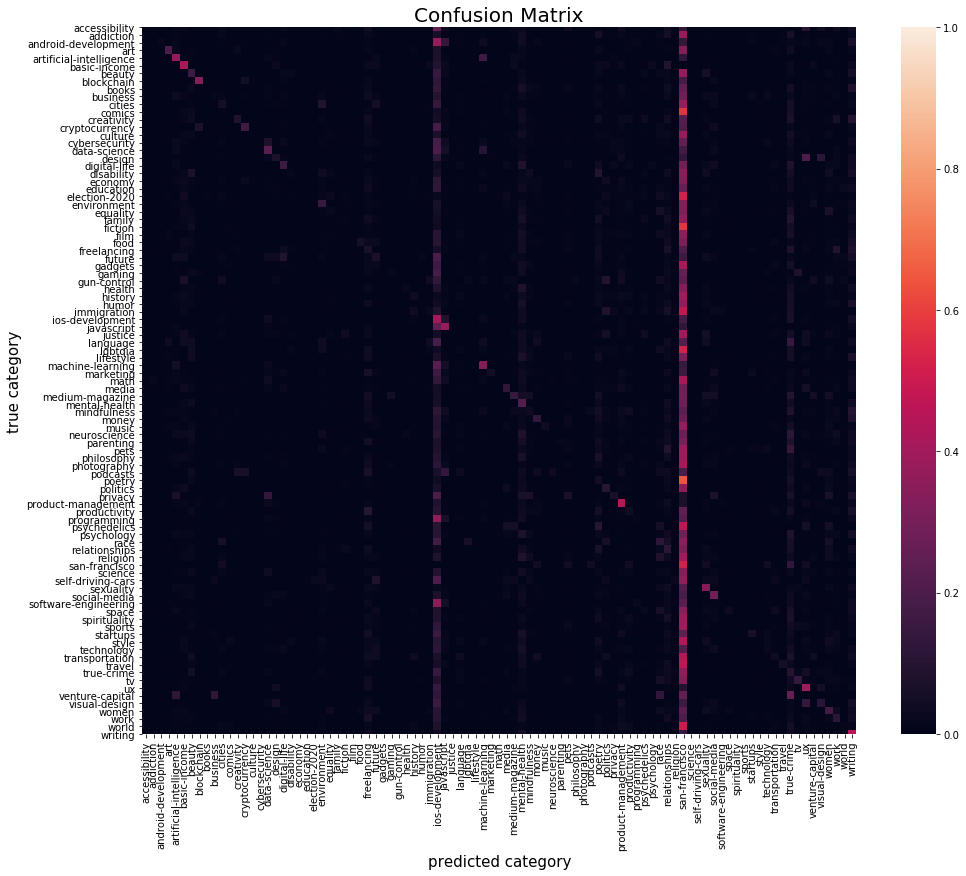

In [29]:
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import TruncatedSVD

vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, stop_words='english')
dimension_reducer = TruncatedSVD(n_components=100)
NBclassifier = GaussianNB()

classifier = Pipeline([("TfIdf", vectorizer),("PCA", dimension_reducer) , ("NaiveBayess", NBclassifier)])
parameter_space = {"TfIdf__ngram_range": [(1, 1), (1, 2), (1, 3)],\
                   "TfIdf__min_df": [1, 2, 10, 100],\
                   "TfIdf__max_df": [0.1, 0.25, 0.5],}
searcherReducedDim = GridSearchCV(classifier, parameter_space, cv=5, n_jobs=-2)
searcherReducedDim.fit(X_train, y_train)

best_parameter = searcherReducedDim.best_params_
print("hyper-parameter of choice: " + str(best_parameter))

y_pred = searcherReducedDim.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("accuracy = {}".format(accuracy))

cMatrix = confusion_matrix(y_test, y_pred, labels=category_list)

plotConfusionMatrix(cMatrix, category_list)

precision = precisionFromConfusionMatrix(cMatrix)
print("Average multiclass precision: {}".format(precision))

Based on preliminary analysis, we tried to reduce the dimensionality of the vector representation with PCA; the low-dimension representation was then used in a Gaussian naive Bayess classifier. We could only achieve a accuracy of about 10% on the test set.